In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
plt.style.use('seaborn-v0_8')
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, KernelPCA
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings("ignore")

In [46]:
data = pd.read_csv('../Datasets/contaminantes_2022.csv', skiprows=10)

In [47]:
print(f'Dataset has {data.shape[0]} rows and {data.shape[1]} columns.')

Dataset has 949488 rows and 5 columns.


In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 949488 entries, 0 to 949487
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   date          949488 non-null  object 
 1   id_station    949488 non-null  object 
 2   id_parameter  949488 non-null  object 
 3   value         614705 non-null  float64
 4   unit          949488 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 36.2+ MB


In [49]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
value,614705.0,21.845807,26.884421,0.0,2.0,14.0,32.0,773.0
unit,949488.0,2.958015,4.511454,1.0,1.0,1.0,2.0,15.0


In [50]:
dataco = data.loc[data['id_parameter'] == 'CO',['id_station','value']]
stations = np.unique(dataco['id_station'])
dataco = dataco.groupby('id_station')
counts_na = {}
for station in stations:
    counts_na[station] = dataco.get_group(station)['value'].isna().sum()
    print(f'{station} has {counts_na[station]} NA values.')

ACO has 1118 NA values.
AJM has 3184 NA values.
ATI has 975 NA values.
BJU has 182 NA values.
CAM has 1408 NA values.
CCA has 263 NA values.
CHO has 990 NA values.
CUA has 291 NA values.
FAC has 586 NA values.
FAR has 445 NA values.
HGM has 3624 NA values.
INN has 137 NA values.
IZT has 990 NA values.
LLA has 3624 NA values.
LPR has 288 NA values.
MER has 149 NA values.
MGH has 421 NA values.
MON has 846 NA values.
MPA has 1106 NA values.
NEZ has 438 NA values.
PED has 584 NA values.
SAC has 660 NA values.
SAG has 173 NA values.
SFE has 1151 NA values.
SJA has 3624 NA values.
TAH has 933 NA values.
TLA has 724 NA values.
TLI has 224 NA values.
UAX has 267 NA values.
UIZ has 650 NA values.
VIF has 237 NA values.
XAL has 3624 NA values.


In [51]:
min_na = min(counts_na, key=lambda x: counts_na[x])
print(f'Station {min_na} has the lowest NA count with {counts_na[min_na]} NA values.')

Station INN has the lowest NA count with 137 NA values.


In [52]:
INN = pd.DataFrame(data.loc[((data['id_station'] ==  min_na) & (data['id_parameter'] == 'CO')),['date','value']])

In [53]:
INN.index = range(len(INN))

In [54]:
import pandas as pd
import numpy as np

def fill_na_with_average(series):
    filled_series = series.copy()
    
    for i in range(len(series)):
        if pd.isna(series[i]):
            next_value = None
            for j in range(i + 1, len(series)):
                if not pd.isna(series[j]):
                    next_value = series[j]
                    break
            
            previous_value = None
            for j in range(i - 1, -1, -1):
                if not pd.isna(series[j]):
                    previous_value = series[j]
                    break
            
            if next_value is not None and previous_value is not None:
                filled_series[i] = np.mean([previous_value, next_value])
            elif next_value is not None:
                filled_series[i] = next_value
            elif previous_value is not None:
                filled_series[i] = previous_value

    return filled_series


In [55]:
INN['value'] = fill_na_with_average(INN['value'])

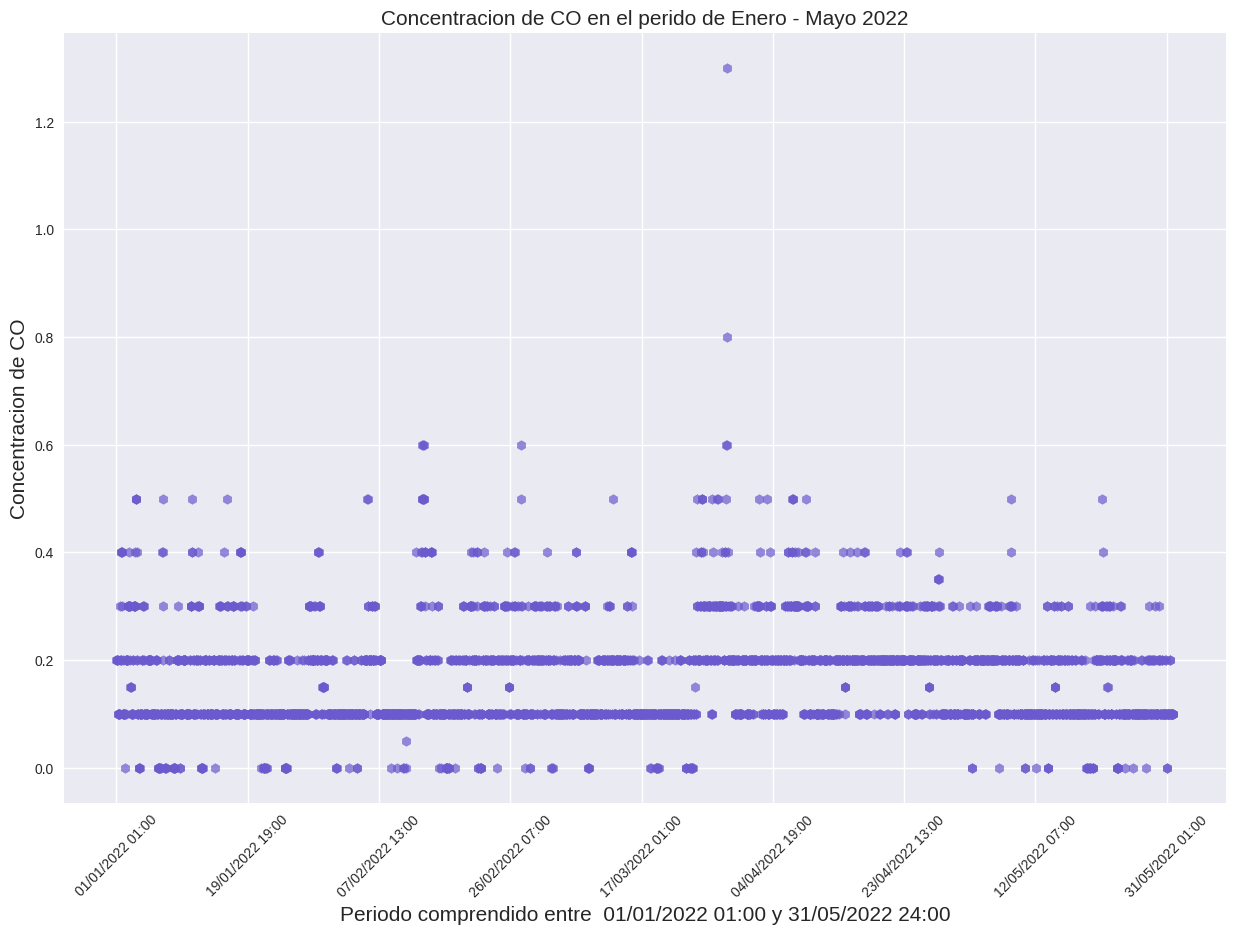

In [56]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title('Concentracion de CO en el perido de Enero - Mayo 2022', fontdict={'fontsize':15})
ax.scatter(range(len(INN['date'])), INN['value'], color = 'slateblue', marker = 'h', alpha= 0.7)
ax.set_xticks(list(range(0,4000,450)))
ax.set_xticklabels(INN.loc[list(range(0,4000,450)),'date'].values, rotation = 45)
ax.set_xlabel('Periodo comprendido entre  01/01/2022 01:00 y 31/05/2022 24:00', fontdict={'fontsize':15})
ax.set_ylabel('Concentracion de CO',  fontdict={'fontsize':15})
plt.show()

In [57]:
def find_outliers_ut(arr, umbral):
    media = np.mean(arr)
    desviacion_estandar = np.std(arr)
    
    z_scores = (arr - media) / desviacion_estandar
    
    index_outliers = np.where(np.abs(z_scores) > umbral)[0]
    
    return index_outliers

In [96]:
umbral = 2
outliers = find_outliers_ut(INN['value'], umbral)

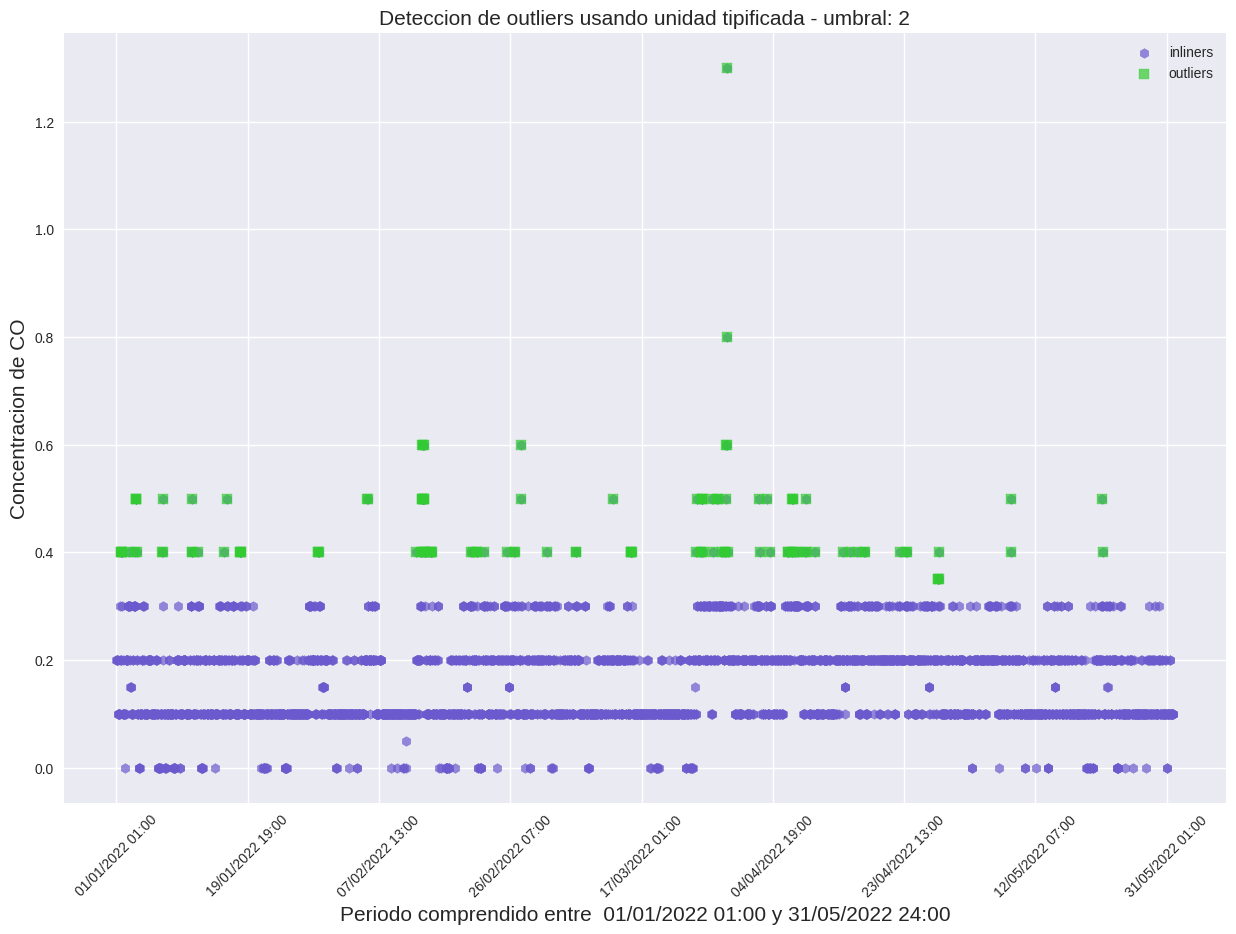

In [97]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title(f'Deteccion de outliers usando unidad tipificada - umbral: {umbral}', fontdict={'fontsize':15})
ax.scatter(range(len(INN['date'])), INN['value'], color = 'slateblue', marker = 'h', alpha= 0.7, label = 'inliners')
ax.scatter(outliers, INN['value'].loc[outliers], color = 'limegreen', marker = 's', alpha= 0.7, label = 'outliers')
ax.set_xticks(list(range(0,4000,450)))
ax.set_xticklabels(INN.loc[list(range(0,4000,450)),'date'].values, rotation = 45)
ax.set_xlabel('Periodo comprendido entre  01/01/2022 01:00 y 31/05/2022 24:00', fontdict={'fontsize':15})
ax.set_ylabel('Concentracion de CO',  fontdict={'fontsize':15})
ax.legend()
plt.show()

In [98]:
def find_outliers_utm(arr, umbral):
    mediana = np.median(arr)
    
    desviacion_absoluta = np.abs(arr - mediana)
    
    limite_inferior = mediana - umbral * np.median(desviacion_absoluta)
    limite_superior = mediana + umbral * np.median(desviacion_absoluta)
    
    index_outliers = np.where((arr < limite_inferior) | (arr > limite_superior))[0]
    
    return index_outliers

In [99]:
umbral = 2
outliers = find_outliers_utm(INN['value'], umbral)

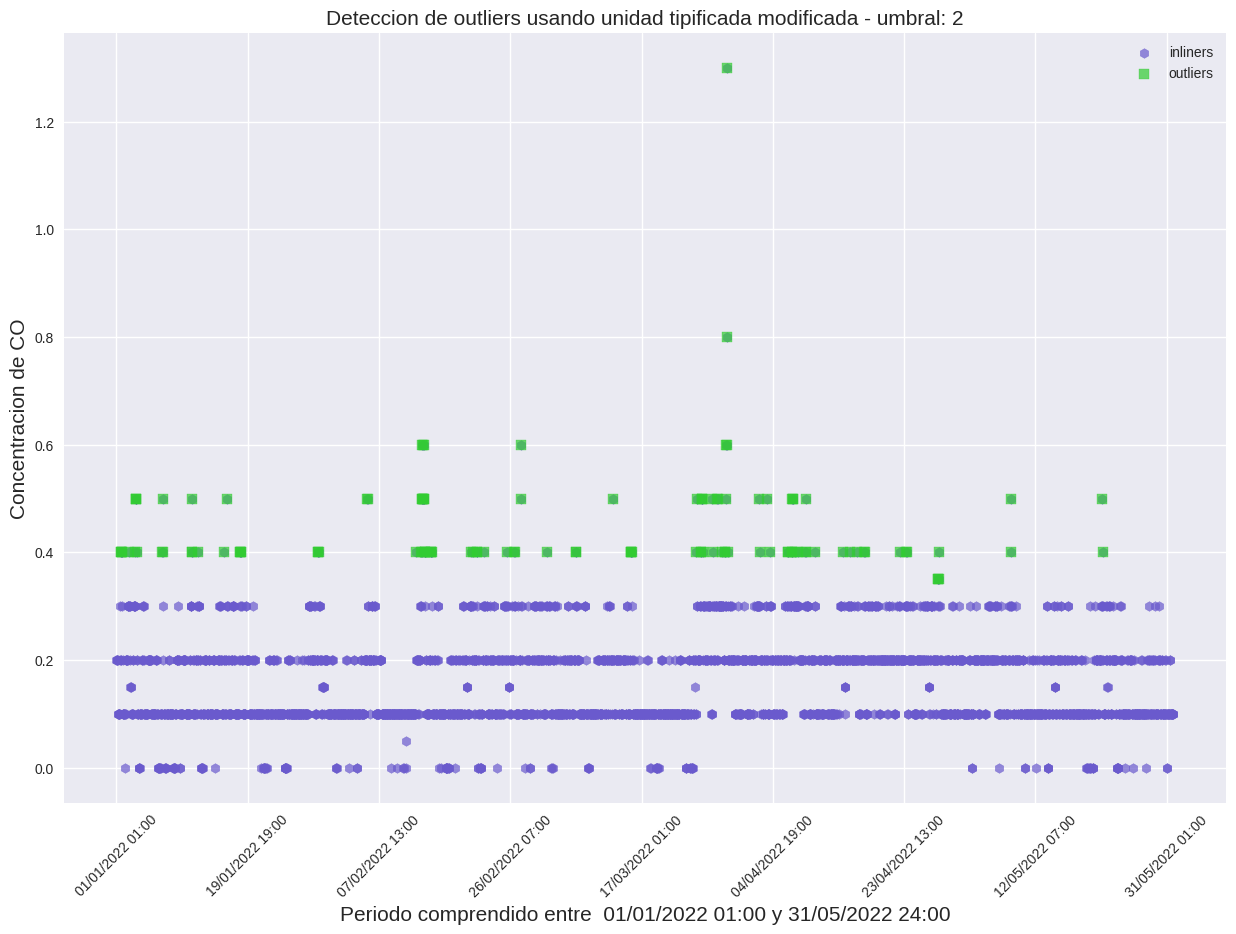

In [100]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title(f'Deteccion de outliers usando unidad tipificada modificada - umbral: {umbral}', fontdict={'fontsize':15})
ax.scatter(range(len(INN['date'])), INN['value'], color = 'slateblue', marker = 'h', alpha= 0.7, label = 'inliners')
ax.scatter(outliers, INN['value'].loc[outliers], color = 'limegreen', marker = 's', alpha= 0.7, label = 'outliers')
ax.set_xticks(list(range(0,4000,450)))
ax.set_xticklabels(INN.loc[list(range(0,4000,450)),'date'].values, rotation = 45)
ax.set_xlabel('Periodo comprendido entre  01/01/2022 01:00 y 31/05/2022 24:00', fontdict={'fontsize':15})
ax.set_ylabel('Concentracion de CO',  fontdict={'fontsize':15})
ax.legend()
plt.show()

In [63]:
parameters = ['CO','NO','SO2']

In [64]:
dataco = data.loc[data['id_parameter'].isin(parameters),['id_station','id_parameter','value']]
stations = np.unique(dataco['id_station'])
dataco = dataco.groupby('id_station')

In [101]:
min_st = ''
min_sum = data.shape[0]
for station in stations:
    subset = dataco.get_group(station)
    co_na = subset.loc[subset['id_parameter'] == 'CO', 'value'].isna().sum()
    no_na = subset.loc[subset['id_parameter'] == 'NO', 'value'].isna().sum()
    so_na = subset.loc[subset['id_parameter'] == 'SO2', 'value'].isna().sum()
    if co_na > 0 and no_na > 0 and so_na > 0:
        s = co_na+no_na+so_na
        if s < min_sum:
            min_sum = s
            min_st = station
            
print(f'Station {min_st} has the lowest NA count with {min_sum} NA values.')

Station TLI has the lowest NA count with 685 NA values.


In [110]:
TLI = pd.DataFrame(data.loc[((data['id_station'] ==  min_st) & (data['id_parameter'].isin(parameters))),['date','id_parameter','value']])
TLI.index = range(len(TLI))

In [111]:
for p in parameters:
    print(f"{TLI.loc[TLI['id_parameter'] == p,'value'].isna().sum()}")

224
217
244


In [112]:
for p in parameters:
    TLI[p] = TLI.loc[TLI['id_parameter'] == p,'value']

In [113]:
TLI = TLI.drop(columns=['id_parameter','value'])

In [114]:
for p in parameters:
    TLI[p] = fill_na_with_average(TLI[p])

In [115]:
TLI.describe().T

,count,mean,std,min,25%,50%,75%,max
CO,10872.0,0.437058,0.391024,0.0,0.2,0.3,0.55,3.1
NO,10872.0,16.815535,29.800554,0.0,1.0,3.5,17.00,273.0
SO2,10872.0,6.086231,10.474926,0.0,1.5,2.5,5.00,112.0


In [72]:
X = TLI.iloc[:, 1: ].values

In [73]:
sc = StandardScaler()
sc.fit(X)

StandardScaler()

In [74]:
X_std = sc.transform(X)

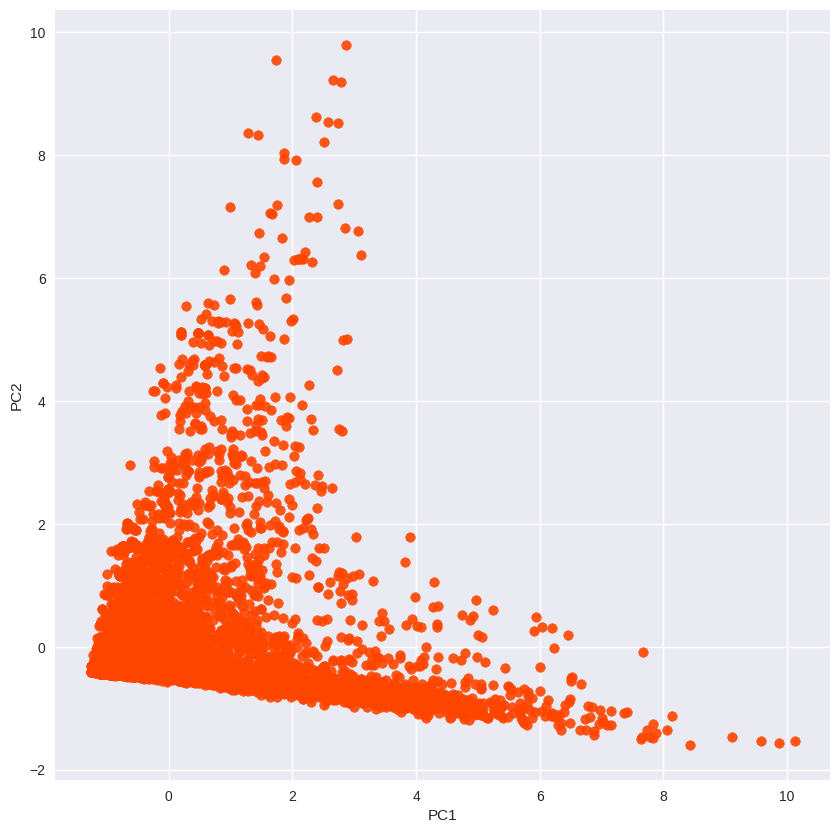

In [75]:
pca = PCA(n_components=2)
pca.fit(X_std)
X_pca = pca.transform(X_std)
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(X_pca[:,0],X_pca[:,1], color = 'orangered', alpha = 0.9)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
plt.show()

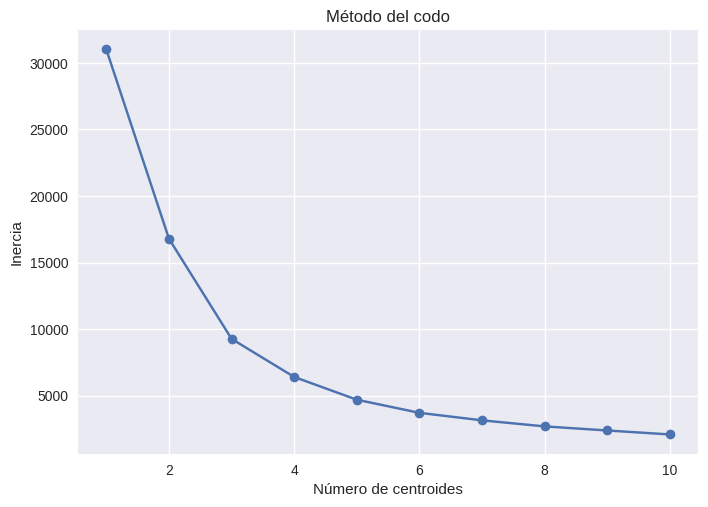

In [76]:
max_clusters = 10
inertias = []
for k in range(1, max_clusters+1):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_pca)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, max_clusters+1), inertias, marker='o')
plt.xlabel('Número de centroides')
plt.ylabel('Inercia')
plt.title('Método del codo')
plt.show()

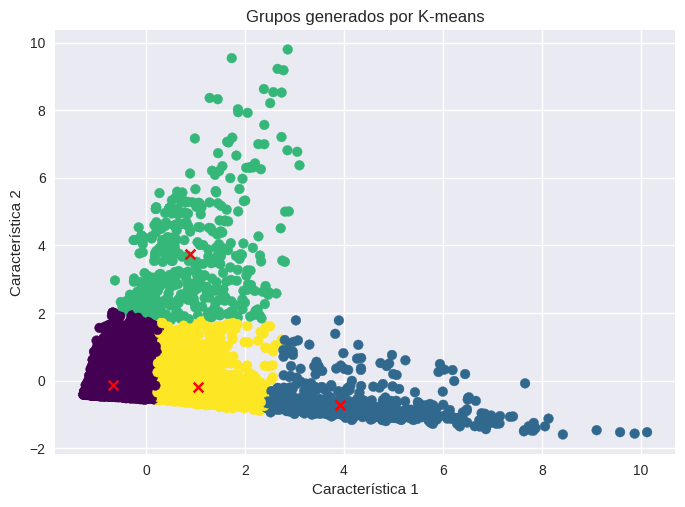

In [89]:
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(X_pca)
labels = kmeans.labels_

# Mostrar gráfico de dispersión de los grupos generados por K-means
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', color='red')
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.title('Grupos generados por K-means')
plt.show()

In [90]:
distances = cdist(X_pca, kmeans.cluster_centers_, 'euclidean')

In [91]:
avg_distances = np.mean(distances, axis=1)

In [92]:
threshold = np.mean(avg_distances) + 2 * np.std(avg_distances)

In [93]:
outliers = np.where(avg_distances > threshold)[0]

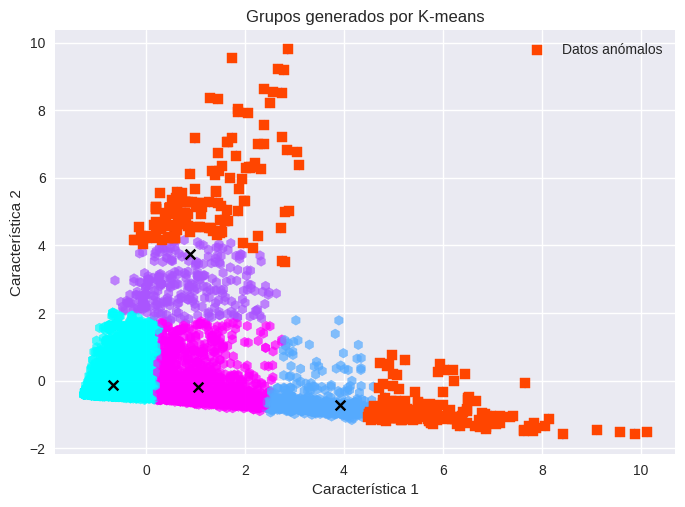

In [94]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='cool', alpha = 0.7, marker = 'h')
plt.scatter(X_pca[outliers, 0], X_pca[outliers, 1], c='orangered', marker = 's', label='Datos anómalos')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', color='black')
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.legend()
plt.title('Grupos generados por K-means')
plt.show()